# Subgroup Discovery Performance vs. Sample Size

# I. Importing libraries

In [681]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, sem
from tqdm import tqdm
from lineartree import LinearTreeRegressor
from copy import deepcopy
from tabulate import tabulate
from utils.data_loader import *
from utils.methods import *
from sklearn.svm import SVR
from matplotlib.patches import Rectangle



# II. Experiment Setup

In [759]:

np.random.seed(103)

def gen_data(n, d, std_in, std_out, beta, R, B):
    X = (B[:, 1] - B[:, 0]) * np.random.rand(n, d) + B[:, 0]
    X = np.concatenate([X, np.ones((n, 1))], axis = 1)
    Y = np.zeros(n)
    for i, x in enumerate(X):
        if in_box(x[:-1], R):
            Y[i] = np.dot(x, beta) + std_in * np.random.randn()
        else:
            Y[i] = std_out * np.random.randn()
    return X, Y


# DDGroup methods
# Get labels from generic threshold
def get_labels(X, Y, g1, g2, std, beta):
    n = len(Y)
    labels = np.zeros(n)
    for k in range(n):
        x = X[k]
        y = Y[k]
        if res(x, y, beta) > std * (g1 * np.linalg.norm(x) + g2):
            labels[k] = 1
    return labels


# LMT methods
# Method for reconstructing bounding box from LMT node
# Input: B, LMT, node
# Output: Region described by node + B
def path_to_node(node, LMT):
    summary = LMT.summary()
    if node == 0:
        return [0]
    else:
        for other_node in summary:
            if node in summary[other_node]['children']:
                parent = other_node
                return path_to_node(parent, LMT) + [node]
        raise Exception(f"Error: Node {node} not found in LMT.")


def node_to_region(node, LMT, B):
    path = path_to_node(node, LMT)
    if len(path) == 1:
        return deepcopy(B)
    
    summary = LMT.summary()
    R_hat = deepcopy(B)
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i+1]
        assert next_node in summary[current_node]['children'], f"Invalid path: Node {next_node} is not a child of node {current_node}."
        if next_node == summary[current_node]['children'][0]: # Next node is the left child of current node, meaning this split constitutes an *upper* bound
            R_hat[summary[current_node]['col'], 1] = summary[current_node]['th']
        else: # Otherwise, next node is the right child, so this split is a *lower* bound.
            R_hat[summary[current_node]['col'], 0] = summary[current_node]['th']
    
    return R_hat


In [760]:
# Constants
d = 2
std_in = 0.3
std_out = 5.
bias = 10.

beta = np.array([1., 1., 20.])
R = np.array([[-1/3, 1/3], [-1/3, 1/3]])

B = np.ones((d, 2))
B[:, 0] *= -1


# Experiment parameters & method hyperparams
num_trials = 20
ns = [200, 400, 800, 1600, 3200, 6400]#, 12800]
g1s = [0.]
g2s = [2., 4., 8., 16., 32., 64.]

# III. DDGroup - LMT - Clustering

### 3.1. Model Training

In [862]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)
res_dict = {n: [] for n in ns}
cluster_res_dict = {n: [] for n in ns}
lmt_res_dict = {n: [] for n in ns}

data_storage_paper = {n: {"X_train": [], "X_val": [], "Y_train": [], "Y_val": []} for n in ns}

for n in tqdm(ns):
    for rep in range(num_trials):
        X, Y = gen_data(n, d, std_in, std_out, beta, R, B)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

        # Save the generated data for later use
        data_storage_paper[n]["X_train"].append(X_train)
        data_storage_paper[n]["X_val"].append(X_val)
        data_storage_paper[n]["Y_train"].append(Y_train)
        data_storage_paper[n]["Y_val"].append(Y_val)

        # DDGroup
        n_core = int(len(Y_train) / 20)
        X_core, Y_core = neighbor_core(X_train, Y_train, n_core)
        beta_hat, _, s_hat = core_fit(X_core, Y_core)
        # print(s_hat)

        valid_regions = []
        for g1 in g1s:
            for g2 in g2s:
                labels = get_labels(X_train, Y_train, g1, g2, s_hat, beta_hat)
                R_hat = hard_grow_region(X_train[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                rmse_val = np.sqrt(np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2))
                if rmse_val <= 8 * s_hat:
                    valid_regions.append(R_hat)
        
        largest_vol = 0
        for R_hat in valid_regions:
            vol = box_intersection(R_hat, R_hat)
            if vol > largest_vol:
                best_R = R_hat
                largest_vol = vol
        
        res_dict[n].append(best_R)

        
        # k-means
        # Currently, we select the region with lowest validation error, which isn't quite the same as DDGroup
        best_val_mse = np.inf
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=100).fit(X_train)
            best_mse = np.inf
            for i in range(k):
                X_core = X_train[kmeans.labels_ == i]
                Y_core = Y_train[kmeans.labels_ == i]

                if len(Y_core) == 0:
                    continue

                beta_hat, _, s_hat = core_fit(X_core, Y_core)
                mse = np.mean((X_core @ beta_hat - Y_core) ** 2)
                if mse < best_mse:
                    best_cluster = i
                    beta_best = beta_hat
                
                X_best = X_train[kmeans.labels_ == best_cluster]
                R_hat = np.zeros((d, 2))
                for j in range(d):
                    R_hat[j, 0] = min(X_best[:, j])
                    R_hat[j, 1] = max(X_best[:, j])
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                mse_val = np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2)
                if mse_val < best_val_mse:
                    best_cluster_region = R_hat
        
        cluster_res_dict[n].append(best_cluster_region)


        # LMT
        r = []
        for max_depth in range(1, 10):
            regr = LinearTreeRegressor(base_estimator=LinearRegression(), max_depth=max_depth)
            regr.fit(X_train, Y_train)

            info = np.array([[node, value['samples'], value['loss']] for node, value in regr.summary().items() if type(value['models']) is not tuple])
            node_use = int(info[np.argmin(info[:, 2]), 0]) 
            inds_train = (regr.apply(X_train)==node_use)
            inds_val = (regr.apply(X_val)==node_use)
            model_leaf = LinearRegression(n_jobs=-1).fit(X_train[inds_train, :], Y_train[inds_train])
            y_pred_val = model_leaf.predict(X_val[inds_val, :])
            mse_val = mean_squared_error(Y_val[inds_val], y_pred_val) 
            # MSE on validation set
            r.append([mse_val, regr, node_use])

        r = np.array(r)
        # The depth with smallest MSE on validation set
        best_lmt = np.argmin(r[:, 0])
        lmt_res_dict[n].append(node_to_region(r[best_lmt, 2], r[best_lmt, 1], B))
    

100%|██████████| 6/6 [04:46<00:00, 47.75s/it]


### 3.2. Precision, Recall, F1 calculation

In [763]:
p_array  = np.zeros((len(ns), num_trials))
r_array  = np.zeros((len(ns), num_trials))
f1_array = np.zeros((len(ns), num_trials))

clust_p_array  = np.zeros((len(ns), num_trials))
clust_r_array  = np.zeros((len(ns), num_trials))
clust_f1_array = np.zeros((len(ns), num_trials))

lmt_p_array  = np.zeros((len(ns), num_trials))
lmt_r_array  = np.zeros((len(ns), num_trials))
lmt_f1_array = np.zeros((len(ns), num_trials))

xgb_p_array  = np.zeros((len(ns), num_trials))
xgb_r_array  = np.zeros((len(ns), num_trials))
xgb_f1_array = np.zeros((len(ns), num_trials))

for i, n in enumerate(ns):
    # DDGroup
    p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in res_dict[n]]
    r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in res_dict[n]]
    f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(p_array[i], r_array[i])]

    # Clustering
    clust_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in cluster_res_dict[n]]
    clust_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in cluster_res_dict[n]]
    clust_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(clust_p_array[i], clust_r_array[i])]

    # LMT
    lmt_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in lmt_res_dict[n]]
    lmt_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in lmt_res_dict[n]]
    lmt_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(lmt_p_array[i], lmt_r_array[i])]

### 3.3. Visualisations

a. F1-values

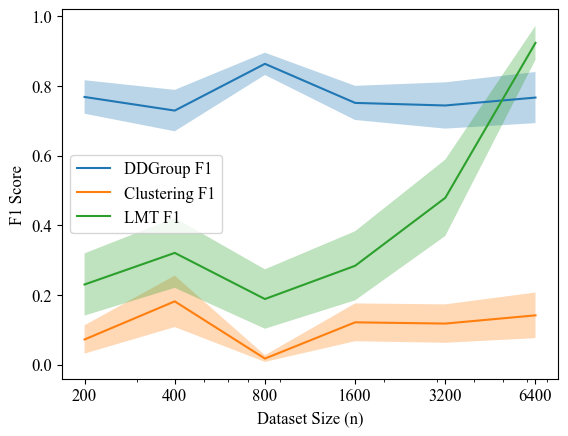

In [764]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up font to match the image
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 12

# Plot F1-scores for all methods excluding XGBoost
plt.plot(ns, np.mean(f1_array, axis=1), label='DDGroup F1')
plt.fill_between(ns, np.mean(f1_array, axis=1) + sem(f1_array, axis=1), np.mean(f1_array, axis=1) - sem(f1_array, axis=1), alpha=0.3)

plt.plot(ns, np.mean(clust_f1_array, axis=1), label='Clustering F1')
plt.fill_between(ns, np.mean(clust_f1_array, axis=1) + sem(clust_f1_array, axis=1), np.mean(clust_f1_array, axis=1) - sem(clust_f1_array, axis=1), alpha=0.3)

plt.plot(ns, np.mean(lmt_f1_array, axis=1), label='LMT F1')
plt.fill_between(ns, np.mean(lmt_f1_array, axis=1) + sem(lmt_f1_array, axis=1), np.mean(lmt_f1_array, axis=1) - sem(lmt_f1_array, axis=1), alpha=0.3)

# Logarithmic x-axis
plt.xscale('log')
plt.xticks(ns, ns)

# Add labels for x and y axes
plt.xlabel('Dataset Size (n)')
plt.ylabel('F1 Score')

# Remove the grid lines
plt.grid(False)

# Add legend
plt.legend()

# Show the plot
plt.show()


b. Precisions

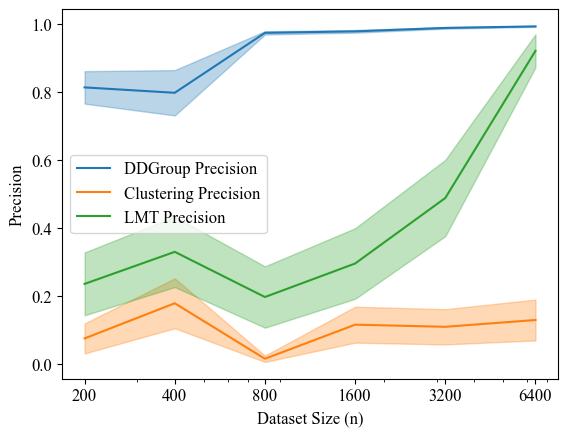

In [765]:
line = plt.plot(ns, np.mean(p_array, axis=1), label='DDGroup Precision')
plt.fill_between(ns, np.mean(p_array, axis=1) + sem(p_array, axis=1), np.mean(p_array, axis=1) - sem(p_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(clust_p_array, axis=1), label='Clustering Precision')
plt.fill_between(ns, np.mean(clust_p_array, axis=1) + sem(clust_p_array, axis=1), np.mean(clust_p_array, axis=1) - sem(clust_p_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(lmt_p_array, axis=1), label='LMT Precision')
plt.fill_between(ns, np.mean(lmt_p_array, axis=1) + sem(lmt_p_array, axis=1), np.mean(lmt_p_array, axis=1) - sem(lmt_p_array, axis=1), alpha=0.3, color=line[0].get_color())

# Formatting to match the previous F1 plot
plt.xscale('log')
plt.xticks(ns, ns)
plt.xlabel("Dataset Size (n)")
plt.ylabel("Precision")
plt.legend()
plt.show()


c. Recall

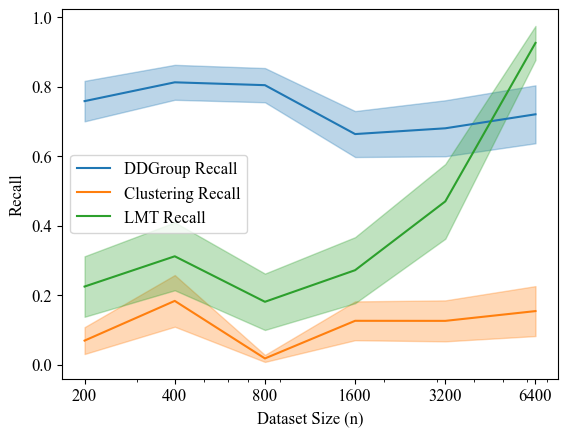

In [766]:
line = plt.plot(ns, np.mean(r_array, axis=1), label='DDGroup Recall')
plt.fill_between(ns, np.mean(r_array, axis=1) + sem(r_array, axis=1), np.mean(r_array, axis=1) - sem(r_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(clust_r_array, axis=1), label='Clustering Recall')
plt.fill_between(ns, np.mean(clust_r_array, axis=1) + sem(clust_r_array, axis=1), np.mean(clust_r_array, axis=1) - sem(clust_r_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(lmt_r_array, axis=1), label='LMT Recall')
plt.fill_between(ns, np.mean(lmt_r_array, axis=1) + sem(lmt_r_array, axis=1), np.mean(lmt_r_array, axis=1) - sem(lmt_r_array, axis=1), alpha=0.3, color=line[0].get_color())

# Formatting to match the previous F1 plot
plt.xscale('log')
plt.xticks(ns, ns)
plt.xlabel("Dataset Size (n)")
plt.ylabel("Recall")
plt.legend()
plt.show()

### 3.4. Summary Table

In [767]:
# Calculate mean and standard error for each method
f1_mean = np.mean(f1_array, axis=1)
f1_sem = sem(f1_array, axis=1)

clust_f1_mean = np.mean(clust_f1_array, axis=1)
clust_f1_sem = sem(clust_f1_array, axis=1)

lmt_f1_mean = np.mean(lmt_f1_array, axis=1)
lmt_f1_sem = sem(lmt_f1_array, axis=1)

# Create a list of lists for the table data
table_data = []
for i, n in enumerate(ns):
    table_data.append([
        n,
        f"{f1_mean[i]:.2f} ± {f1_sem[i]:.2f}",
        f"{clust_f1_mean[i]:.2f} ± {clust_f1_sem[i]:.2f}",
        f"{lmt_f1_mean[i]:.2f} ± {lmt_f1_sem[i]:.2f}"
    ])

# Create the table headers
headers = ["Sample Size", "DDGroup F1", "Clustering F1", "LMT F1"]

# Generate the Markdown table using the tabulate library
table = tabulate(table_data, headers=headers, tablefmt="pipe")

# Print the table
print(table)

|   Sample Size | DDGroup F1   | Clustering F1   | LMT F1      |
|--------------:|:-------------|:----------------|:------------|
|           200 | 0.77 ± 0.05  | 0.07 ± 0.04     | 0.23 ± 0.09 |
|           400 | 0.73 ± 0.06  | 0.18 ± 0.07     | 0.32 ± 0.10 |
|           800 | 0.86 ± 0.03  | 0.02 ± 0.01     | 0.19 ± 0.09 |
|          1600 | 0.75 ± 0.05  | 0.12 ± 0.05     | 0.28 ± 0.10 |
|          3200 | 0.74 ± 0.07  | 0.12 ± 0.06     | 0.48 ± 0.11 |
|          6400 | 0.77 ± 0.07  | 0.14 ± 0.07     | 0.92 ± 0.05 |


# IV. New Methods

### **Gradient Boosting Machine (GBM)**

The GBM model is designed to identify regions within the feature space by using decision trees. Each leaf in the decision tree assigns data points to a specific region. The model iterates over different tree depths to select the best-performing model, determined by the lowest validation Mean Squared Error (MSE). Key parameters such as n_estimators (number of trees), learning_rate, and max_depth are tuned for optimal performance. The final regions are extracted by identifying the boundaries of the data points assigned to each leaf, using the minimum and maximum values for each feature within the region.



### **Support Vector Machine (SVM)**

The SVM model is configured to identify nonlinear boundaries in the data using the Radial Basis Function (RBF) kernel. Different values of the regularization parameter C are tested to control the trade-off between margin size and misclassification. The model learns to separate data points into regions based on support vectors, and the best region is selected by evaluating the validation MSE. Linear and polynomial kernels were also tested, but the RBF kernel was found to perform best for capturing the nonlinear relationships in the data.



### 4.1 Model Training



In [863]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)

# Dictionaries to store regions extracted by SVM and GBM for each dataset size (n) and trial (rep)
svm_res_dict = {n: [] for n in ns} 
gbm_res_dict = {n: [] for n in ns} 

# Dictionary to store data for later visualization (includes X_train, X_val, Y_train, Y_val for each dataset size n)
data_storage = {n: {"X_train": [], "X_val": [], "Y_train": [], "Y_val": []} for n in ns}

# Loop through different dataset sizes
for n in tqdm(ns):
    for rep in range(num_trials):

        # ------------------------------------ DATA GENERATION ------------------------------------
        # Generate synthetic data using the gen_data function
        X, Y = gen_data(n, d, std_in, std_out, beta, R, B)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

        # Save the generated data for later use
        data_storage[n]["X_train"].append(X_train)
        data_storage[n]["X_val"].append(X_val)
        data_storage[n]["Y_train"].append(Y_train)
        data_storage[n]["Y_val"].append(Y_val)

        # ------------------------------------ GBM MODEL ------------------------------------
        # List to store the MSE values for different max_depths during the GBM model training
        r = []

        # Iterate over different max_depth values for GBM (varying from 1 to 5)
        for max_depth in range(1, 5):  # You can adjust the range of max_depth values
            # Initialize and train the GBM model with specific hyperparameters
            gbm_model = GradientBoostingRegressor(
                n_estimators=30,       # Number of trees
                max_depth=max_depth,   # Varying max_depth
                learning_rate=0.05,    # Learning rate for gradient descent
                subsample=0.9,         # Subsample ratio
                random_state=40,       # Ensuring reproducibility
                loss='huber'           # Huber loss for robustness to outliers
            )
            
            # Fit the GBM model to the training data
            gbm_model.fit(X_train, Y_train)
            
            # Extract regions based on the leaf structure of the GBM trees
            gbm_regions = extract_gbm_regions(gbm_model, X_train, X_val)
            
            # Predict values on the validation set and calculate the MSE
            y_pred_val = gbm_model.predict(X_val)
            mse_val = mean_squared_error(Y_val, y_pred_val)  # MSE on validation set
            
            # Store the MSE and the corresponding region for each max_depth
            r.append([mse_val, gbm_regions])

        # Convert r to a NumPy array for easy processing
        r = np.array(r)
        
        # Find the max_depth that resulted in the smallest MSE
        best_depth_idx = np.argmin(r[:, 0])
        
        # Select the region corresponding to the best performing max_depth
        best_gbm_region = r[best_depth_idx, 1]

        # Store the best region for this dataset size and trial in gbm_res_dict
        gbm_res_dict[n].append(best_gbm_region)

        # ------------------------------------ SVM MODEL (RBF Kernel) ------------------------------------
        # List to store the MSE values for different values of the regularization parameter C
        r = []

        # Define the range of C values to loop over for SVM
        C_values = [0.01, 0.1, 1, 10, 100]  # Regularization parameter values to explore

        # Loop over different C values for SVM with RBF kernel
        for C in C_values:
            # Train the SVM model with the RBF kernel and the current C value
            model = SVR(kernel='rbf', C=C, gamma='auto')
            model.fit(X_train[:, :-1], Y_train)  # Fit SVM on the training data (excluding intercept)
            
            # Predict values on the validation set and calculate the MSE
            y_pred_val = model.predict(X_val[:, :-1])
            mse_val = mean_squared_error(Y_val, y_pred_val)  # MSE on validation set

            # Extract regions based on the "good" points (support vectors) found by the SVM
            pred = model.predict(X_train[:, :-1])
            good_points = X_train[pred >= np.mean(pred), :-1]  # Select points with predictions above average
            
            # If good points are found, define a region based on their boundaries
            if len(good_points) > 0:
                R_hat = np.array([[np.min(good_points[:, i]), np.max(good_points[:, i])] for i in range(good_points.shape[1])])
            else:
                R_hat = np.array([[0, 0] for _ in range(X_train.shape[1] - 1)])  # Default empty region if no good points found

            # Store the MSE and region for the current C value
            r.append([mse_val, R_hat])

        # Convert r to a NumPy array for easy indexing
        r = np.array(r)

        # Find the C value that resulted in the smallest MSE
        best_C_idx = np.argmin(r[:, 0])

        # Select the region corresponding to the best performing C value
        best_svm_region = r[best_C_idx, 1]

        # Store the best region for this dataset size and trial in svm_res_dict
        svm_res_dict[n].append(best_svm_region)


100%|██████████| 6/6 [09:38<00:00, 96.48s/it] 


### 4.2 Precision, Recall, F1 calculation

In [769]:
# Initialize arrays to store Precision, Recall, and F1-Score for GBM and SVM models
gbm_p_array = np.zeros((len(ns), num_trials))  
gbm_r_array = np.zeros((len(ns), num_trials))  
gbm_f1_array = np.zeros((len(ns), num_trials)) 

svm_p_array = np.zeros((len(ns), num_trials))  
svm_r_array = np.zeros((len(ns), num_trials))  
svm_f1_array = np.zeros((len(ns), num_trials)) 

# Iterate through each dataset size (n)
for i, n in enumerate(ns):

    # ------------------------------------ GBM METRICS CALCULATION ------------------------------------
    # Loop through each trial for the GBM model
    for rep in range(num_trials): 
        best_region = None  # Initialize the best region for the current trial
        best_f1 = 0  # Initialize the best F1 score to 0

        # Iterate over all regions extracted by the GBM model for the current trial
        for R_hat in gbm_res_dict[n][rep]:
            # Calculate precision for the current region
            p = 0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat)
            # Calculate recall for the current region
            r = box_intersection(R_hat, R) / box_intersection(R, R)
            # Calculate F1-score for the current region
            f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

            # Update best_region if the current region has a better F1-score than the previous one
            if f1 > best_f1:
                best_f1 = f1
                best_region = R_hat  # Store the best region with the highest F1-score
        
        # After iterating through all regions, calculate the final precision, recall, and F1-score for GBM
        if best_region is not None:
            # Final precision for the best region
            p = 0 if box_intersection(best_region, best_region) == 0 else box_intersection(best_region, R) / box_intersection(best_region, best_region)
            # Final recall for the best region
            r = box_intersection(best_region, R) / box_intersection(R, R)
            # Final F1-score for the best region
            f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

            # Store GBM precision, recall, and F1-score for the current trial
            gbm_p_array[i, rep] = p  
            gbm_r_array[i, rep] = r  
            gbm_f1_array[i, rep] = f1  

    # ------------------------------------ SVM METRICS CALCULATION ------------------------------------
    # Loop through each trial for the SVM model
    for rep in range(num_trials):
        # Get the region extracted by the SVM model for the current trial
        R_hat = svm_res_dict[n][rep]

        # Precision calculation for the SVM region
        p = 0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat)
        
        # Recall calculation for the SVM region
        r = box_intersection(R_hat, R) / box_intersection(R, R)

        # F1-score calculation for the SVM region
        f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

        # Store SVM precision, recall, and F1-score for the current trial
        svm_p_array[i, rep] = p  
        svm_r_array[i, rep] = r  
        svm_f1_array[i, rep] = f1  


### 4.3 Summary table

In [770]:
from tabulate import tabulate

# Calculate mean and standard error for each method
gbm_f1_mean = np.mean(gbm_f1_array, axis=1)
gbm_f1_sem = sem(gbm_f1_array, axis=1)

svm_f1_mean = np.mean(svm_f1_array, axis=1)
svm_f1_sem = sem(svm_f1_array, axis=1)

# Create a list of lists for the table data (include all methods)
table_data = []
for i, n in enumerate(ns):
    table_data.append([
        n,
        f"{f1_mean[i]:.2f} ± {f1_sem[i]:.2f}",
        f"{clust_f1_mean[i]:.2f} ± {clust_f1_sem[i]:.2f}",
        f"{lmt_f1_mean[i]:.2f} ± {lmt_f1_sem[i]:.2f}",
        f"{gbm_f1_mean[i]:.2f} ± {gbm_f1_sem[i]:.2f}",
        f"{svm_f1_mean[i]:.2f} ± {svm_f1_sem[i]:.2f}",
    ])

# Create the table headers (include all methods)
headers = ["Sample Size", "DDGroup F1", "Clustering F1", "LMT F1", "GBM F1", "SVM F1"]

# Generate the Markdown table using the tabulate library
table = tabulate(table_data, headers=headers, tablefmt="pipe")

# Print the table
print(table)


|   Sample Size | DDGroup F1   | Clustering F1   | LMT F1      | GBM F1      | SVM F1      |
|--------------:|:-------------|:----------------|:------------|:------------|:------------|
|           200 | 0.77 ± 0.05  | 0.07 ± 0.04     | 0.23 ± 0.09 | 0.76 ± 0.04 | 0.27 ± 0.01 |
|           400 | 0.73 ± 0.06  | 0.18 ± 0.07     | 0.32 ± 0.10 | 0.85 ± 0.03 | 0.25 ± 0.01 |
|           800 | 0.86 ± 0.03  | 0.02 ± 0.01     | 0.19 ± 0.09 | 0.96 ± 0.01 | 0.21 ± 0.00 |
|          1600 | 0.75 ± 0.05  | 0.12 ± 0.05     | 0.28 ± 0.10 | 0.98 ± 0.00 | 0.21 ± 0.00 |
|          3200 | 0.74 ± 0.07  | 0.12 ± 0.06     | 0.48 ± 0.11 | 0.99 ± 0.00 | 0.20 ± 0.00 |
|          6400 | 0.77 ± 0.07  | 0.14 ± 0.07     | 0.92 ± 0.05 | 0.99 ± 0.00 | 0.20 ± 0.00 |


In [772]:
# Calculate mean and standard error for Precision of each method
gbm_p_mean = np.mean(gbm_p_array, axis=1)
gbm_p_sem = sem(gbm_p_array, axis=1)

svm_p_mean = np.mean(svm_p_array, axis=1)
svm_p_sem = sem(svm_p_array, axis=1)

p_mean = np.mean(p_array, axis=1)
p_sem = sem(p_array, axis=1)

clust_p_mean = np.mean(clust_p_array, axis=1)
clust_p_sem = sem(clust_p_array, axis=1)

lmt_p_mean = np.mean(lmt_p_array, axis=1)
lmt_p_sem = sem(lmt_p_array, axis=1)

# Create a list of lists for the table data (Precision for all methods)
precision_table_data = []
for i, n in enumerate(ns):
    precision_table_data.append([
        n,
        f"{p_mean[i]:.2f} ± {p_sem[i]:.2f}",
        f"{clust_p_mean[i]:.2f} ± {clust_p_sem[i]:.2f}",
        f"{lmt_p_mean[i]:.2f} ± {lmt_p_sem[i]:.2f}",
        f"{gbm_p_mean[i]:.2f} ± {gbm_p_sem[i]:.2f}",
        f"{svm_p_mean[i]:.2f} ± {svm_p_sem[i]:.2f}",
    ])

# Create the table headers for Precision
precision_headers = ["Sample Size", "DDGroup Precision", "Clustering Precision", "LMT Precision", "GBM Precision", "SVM Precision"]

# Generate the Markdown table for Precision using the tabulate library
precision_table = tabulate(precision_table_data, headers=precision_headers, tablefmt="pipe")

# Print the Precision table
print(precision_table)


|   Sample Size | DDGroup Precision   | Clustering Precision   | LMT Precision   | GBM Precision   | SVM Precision   |
|--------------:|:--------------------|:-----------------------|:----------------|:----------------|:----------------|
|           200 | 0.81 ± 0.05         | 0.08 ± 0.04            | 0.24 ± 0.09     | 0.82 ± 0.05     | 0.16 ± 0.01     |
|           400 | 0.80 ± 0.07         | 0.18 ± 0.07            | 0.33 ± 0.10     | 0.91 ± 0.03     | 0.14 ± 0.01     |
|           800 | 0.97 ± 0.00         | 0.02 ± 0.01            | 0.20 ± 0.09     | 0.98 ± 0.01     | 0.12 ± 0.00     |
|          1600 | 0.98 ± 0.00         | 0.12 ± 0.05            | 0.30 ± 0.10     | 0.99 ± 0.00     | 0.11 ± 0.00     |
|          3200 | 0.99 ± 0.00         | 0.11 ± 0.05            | 0.49 ± 0.11     | 1.00 ± 0.00     | 0.11 ± 0.00     |
|          6400 | 0.99 ± 0.00         | 0.13 ± 0.06            | 0.92 ± 0.05     | 1.00 ± 0.00     | 0.11 ± 0.00     |


In [773]:
# Calculate mean and standard error for Recall of each method
gbm_r_mean = np.mean(gbm_r_array, axis=1)
gbm_r_sem = sem(gbm_r_array, axis=1)

svm_r_mean = np.mean(svm_r_array, axis=1)
svm_r_sem = sem(svm_r_array, axis=1)

r_mean = np.mean(r_array, axis=1)
r_sem = sem(r_array, axis=1)

clust_r_mean = np.mean(clust_r_array, axis=1)
clust_r_sem = sem(clust_r_array, axis=1)

lmt_r_mean = np.mean(lmt_r_array, axis=1)
lmt_r_sem = sem(lmt_r_array, axis=1)

# Create a list of lists for the table data (Recall for all methods)
recall_table_data = []
for i, n in enumerate(ns):
    recall_table_data.append([
        n,
        f"{r_mean[i]:.2f} ± {r_sem[i]:.2f}",
        f"{clust_r_mean[i]:.2f} ± {clust_r_sem[i]:.2f}",
        f"{lmt_r_mean[i]:.2f} ± {lmt_r_sem[i]:.2f}",
        f"{gbm_r_mean[i]:.2f} ± {gbm_r_sem[i]:.2f}",
        f"{svm_r_mean[i]:.2f} ± {svm_r_sem[i]:.2f}",
    ])

# Create the table headers for Recall
recall_headers = ["Sample Size", "DDGroup Recall", "Clustering Recall", "LMT Recall", "GBM Recall", "SVM Recall"]

# Generate the Markdown table for Recall using the tabulate library
recall_table = tabulate(recall_table_data, headers=recall_headers, tablefmt="pipe")

# Print the Recall table
print(recall_table)


|   Sample Size | DDGroup Recall   | Clustering Recall   | LMT Recall   | GBM Recall   | SVM Recall   |
|--------------:|:-----------------|:--------------------|:-------------|:-------------|:-------------|
|           200 | 0.76 ± 0.06      | 0.07 ± 0.04         | 0.22 ± 0.09  | 0.75 ± 0.03  | 1.00 ± 0.00  |
|           400 | 0.81 ± 0.05      | 0.18 ± 0.07         | 0.31 ± 0.10  | 0.82 ± 0.03  | 1.00 ± 0.00  |
|           800 | 0.80 ± 0.05      | 0.02 ± 0.01         | 0.18 ± 0.08  | 0.94 ± 0.01  | 1.00 ± 0.00  |
|          1600 | 0.66 ± 0.07      | 0.13 ± 0.06         | 0.27 ± 0.09  | 0.97 ± 0.01  | 1.00 ± 0.00  |
|          3200 | 0.68 ± 0.08      | 0.13 ± 0.06         | 0.47 ± 0.11  | 0.98 ± 0.00  | 1.00 ± 0.00  |
|          6400 | 0.72 ± 0.08      | 0.15 ± 0.07         | 0.93 ± 0.05  | 0.99 ± 0.00  | 1.00 ± 0.00  |


# V. Visual performance

In [877]:
# Visualize XGBoost Region with color-coding based on the generated "good region"
def plot_region_with_colors(X_train, Y_train, R, R_hat, title, label):
    plt.figure(figsize=(6, 6))

    # Separate points that are inside the "good region" (R) and outside it
    inside_good_region = np.array([in_box(x[:-1], R) for x in X_train])
    outside_good_region = ~inside_good_region

    # Color points based on whether they belong to the good region or not
    plt.scatter(X_train[inside_good_region, 0], X_train[inside_good_region, 1], color='blue', label='Good Region', alpha=0.6, s=15)
    plt.scatter(X_train[outside_good_region, 0], X_train[outside_good_region, 1], color='red', label='Outside Good Region', alpha=0.6, s=15)

    # Draw the actual good region as a rectangle
    rect = Rectangle((R[0, 0], R[1, 0]), R[0, 1] - R[0, 0], R[1, 1] - R[1, 0], 
                     linewidth=2, edgecolor='green', facecolor='none', label='True Good Region')
    plt.gca().add_patch(rect)

    # Convert R_hat to a NumPy array if it's a list
    R_hat = np.array(R_hat) if isinstance(R_hat, list) else R_hat

    # Draw the XGBoost identified region as a rectangle (R_hat)
    if R_hat is not None and R_hat.shape[0] == 2:
        rect_xgb = Rectangle((R_hat[0, 0], R_hat[1, 0]), R_hat[0, 1] - R_hat[0, 0], R_hat[1, 1] - R_hat[1, 0], 
                             linewidth=2, edgecolor='orange', facecolor='none', linestyle='--', label=label)
        plt.gca().add_patch(rect_xgb)

    # Labels and legend
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])

    plt.show()

a. GBM

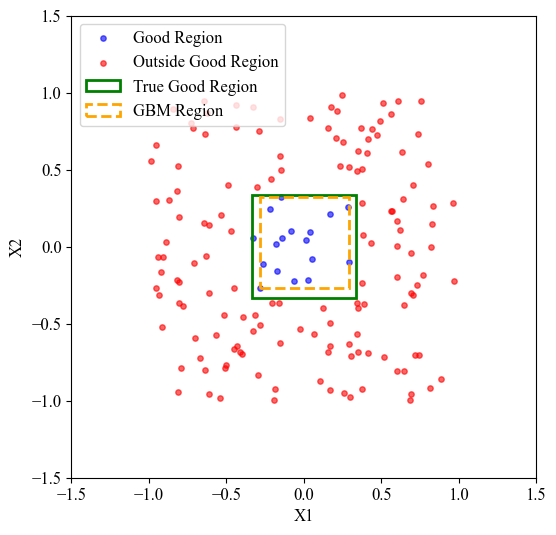

In [878]:
# Visualize XGBoost region for n=200 and rep=0
n = 200
rep = 5
# Access the stored data
X_train = np.array(data_storage[n]["X_train"][rep])
X_val = np.array(data_storage[n]["X_val"][rep])
Y_train = np.array(data_storage[n]["Y_train"][rep])
Y_val = np.array(data_storage[n]["Y_val"][rep])

# Get the XGBoost region from xgb_res_dict
best_region = None
best_f1 = 0  # Use F1-score for selection

for R_hat in gbm_res_dict[n][rep]:
    # Calculate precision and recall for the current region
    p = 0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat)
    r = box_intersection(R_hat, R) / box_intersection(R, R)
    f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

    # Update best_region if current region has a better F1-score
    if f1 > best_f1:
        best_f1 = f1
        best_region = R_hat

# Call the function to visualize
plot_region_with_colors(X_train, Y_train, R, best_region, title=f"GBM Region for n={n}, rep={rep}", label = "GBM Region")

b. SVM

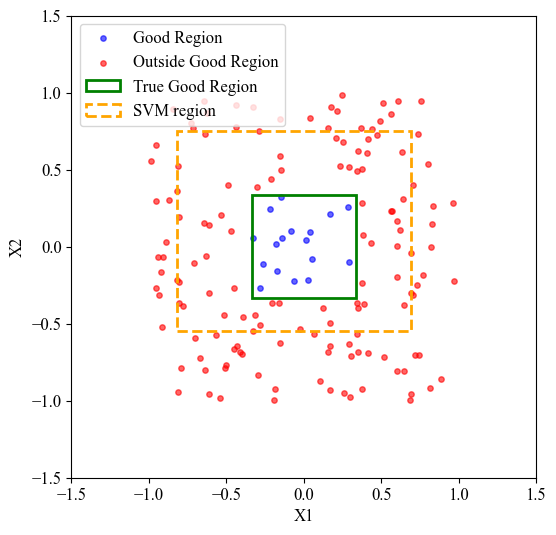

In [879]:
R_hat = svm_res_dict[n][rep]

plot_region_with_colors(X_train, Y_train, R, R_hat, title=f"GBM Region for n={n}, rep={rep}", label="SVM region")

c. DDGroup

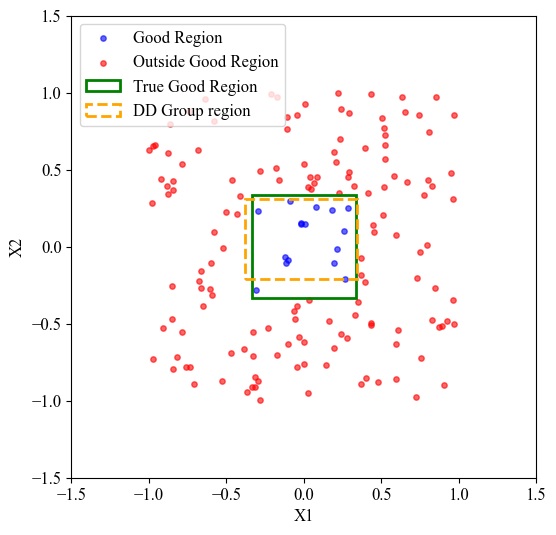

In [884]:
# Access the stored data
X_train = np.array(data_storage_paper[n]["X_train"][rep])
X_val = np.array(data_storage_paper[n]["X_val"][rep])
Y_train = np.array(data_storage_paper[n]["Y_train"][rep])
Y_val = np.array(data_storage_paper[n]["Y_val"][rep])

R_hat = res_dict[n][rep]

plot_region_with_colors(X_train, Y_train, R, R_hat, title=f"GBM Region for n={n}, rep={rep}", label="DD Group region")

d. LMT

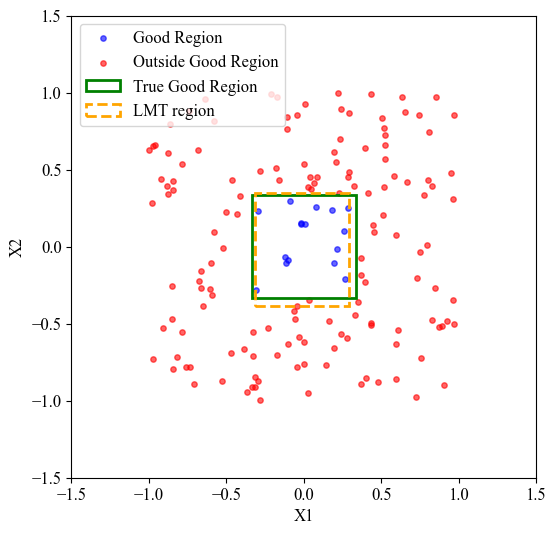

In [895]:
R_hat = lmt_res_dict[n][rep]

plot_region_with_colors(X_train, Y_train, R, R_hat, title=f"GBM Region for n={n}, rep={rep}", label="LMT region")